In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
datetime.datetime.strptime
from pandas import to_datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr


In [ ]:
# Legge il CSV
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)
# Trasforma il campo "Sale" in un float
df["Sale"] = df["Sale"].str.replace(",", ".").astype(float)
# Trasforma il campo "BasketDate" in un datetime
df["BasketDate"] = pd.to_datetime(df["BasketDate"])

df.head()

# DATA SEMANTICS



In [ ]:
df.info()

Nel dataset si descrivono le sessioni di acquisto di un certo numero di clienti. Una sessione di acquisto, detta basket (`BasketID`) e si svolge in una data (`BasketDate`), e viene effettuata da un cliente (CustomerID) residente in uno stato (`CustomerCountry`).
Ogni sessione rappresenta una serie di prodotti acquistati da un cliente, e in un record è possibile ritrovare, per il singolo prodotto, l’identificativo (`ProdID`), la descrizione (`ProdDescr`), e  la quantità (`Qtà`). Infine viene riportato il costo unitario del prodotto (`Sale`).

# DISTRIBUTION OF VARIABLES AND STATISTICS


In [ ]:
df.describe()

In [ ]:
print("Distinct Values in BasketID: \n", df.BasketID.nunique())
print("Distinct Values in BasketDate:\n", df.BasketDate.nunique())
print("Distinct Values in Sale: \n", df.Sale.nunique())
print("Distinct Values in CustomerID: \n", df.CustomerID.nunique())
print("Distinct Values in CustomerCountry: \n", df.CustomerCountry.nunique())
print("Distinct Values in ProdID: \n", df.ProdID.nunique())
print("Distinct Values in ProdDescr: \n", df.ProdDescr.nunique())

## Date e ore di maggiore traffico nei negozi

## Orari di maggiore frequentazione

Di seguito si mostrano i diagrammi a barre contenenti il numero di `BasketID` per ora del giorno.

In [ ]:
df.groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

L'ora del giorno più frequentata sembra essere le 12.

Si restringono le date al 2010 e si osserva come in questo anno l'ora più frequentata siano le 14

In [ ]:
df[df["BasketDate"].dt.year == 2010].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

Mentre nel 2011 l'orario di maggiore frequenza si confermano le 12.

In [ ]:
df[df["BasketDate"].dt.year == 2011].groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

## Date di maggiore frequentazione

Si mostrano le date di maggiore traffico per gli anni 2010 e 2011

Dato che relativamente al 2010 sono presenti solo 20 record è possibile mostrarli in un unico grafico

In [ ]:
df_2010 = df[df["BasketDate"].dt.year == 2010]

print(df_2010["BasketDate"].dt.date.nunique())

df_2010.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

TODO: Grafici per ogni gruppo di mesi del 2011

In [ ]:
first_three_months = df[(df["BasketDate"].dt.year == 2011) & (df["BasketDate"].dt.month < 3 )]

first_three_months.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

## Paesi in cui sono stati effettuati piu acquisti

In [ ]:
df.groupby('CustomerCountry')["BasketID"].nunique().plot(kind='bar',

title='Best buy coutry')

In [ ]:
#verificare a cosa è dovuta la variazione di prezzo
df.groupby(["ProdID",'Qta'])["Sale"].unique()

# ASSESSING DATA QUALITY (MISSING VALUES, OUTLIERS)

In [ ]:
df.info()

Si osserva che le uniche quantità settate a NaN sono `CustomerID` e le `ProdDescr`. I record che non hanno `CustomerID` non portano informazioni riguardo al profilo del cliente, mentre la `ProdDescr` può essere recuperata dai record con lo stesso `ProdID`.

In [ ]:
df = df[~(df["CustomerID"].isnull())]

## Outliers nella quantità (`Qta`)

La distribuzione della quantità segue la seguente distribuzione:

In [ ]:
boxplot = df.boxplot(column=['Qta'])

In [ ]:
df[df["Qta"]<20000].describe()

Eliminiamo quindi i record la cui distanza interquartile è troppo alta:

In [ ]:
def drop_iqr(column, treshold=1.5):
    global df
    data = df[column]
    Q1 = data.quantile(q = 0.25)
    Q3 = data.quantile(q = 0.75)
    IQR = data.apply(iqr)
    #only keep rows in dataframe that have values within treshold*IQR of Q1 and Q3
    df = df[~((df[column] < (Q1-treshold*IQR)) | (df[column] > (Q3+treshold*IQR)))]
drop_iqr("Sale")

In [ ]:
df.boxplot(column=["Qta"])

In [ ]:
df.boxplot(column=["Sale"])

Boxplot raggruppato per paese

In [ ]:
df.boxplot(column=["CustomerID"], by="CustomerCountry")

# Outliers in Sale

In [ ]:
df["Sale"].plot.box()

In [ ]:
df[(df["Sale"] < 0)]
#vengono rimossi

In [ ]:
df=df[(df["Sale"] >= 0)]

In [ ]:
df[df["Sale"] > 30000]
#viene mantenuto in quanto ha informazioni

# VARIABLES TRANSFORMATION & GENERATION

## Prezzo nullo

I record con prezzo 0 si considerano missing values, per cui si cerca di recuperare il valore di `Sale` a partire dalla media dei prezzi dello stesso `ProdID`.

In [ ]:
df["Sale"] = df.groupby("ProdID")["Sale"].transform(lambda group: group.replace(to_replace=0, method="ffill", value = group.mean()))

## ProdDescr non disponibile

Per rendere più interpretabili certe analisi riteniamo che sia utile recuperare la `ProdDescr` degli elementi che non l'hanno settata. Analogamente al caso precedente, si costruisce una funzione che recupera la descrizione di ogni prodotto dagli altri record.

In [ ]:
def replace_first_notna(group: pd.Series, column: str):
    # Indice del primo record con ProdID comune non NaN
    i: int = group.first_valid_index()
    # Se i è None non ci sono ProdDescr valide
    if i is None:
        return group
    # Valore di ProdDescr valido
    value = df.loc[i][column]
    return group.fillna(value)
 
df["ProdDescr"] = df.groupby("ProdID")["ProdDescr"].transform(lambda x: replace_first_notna(x, "ProdDescr"))

In [ ]:
df[df["ProdDescr"].isnull()]

# PAIRWISE CORRELATION & ELIMINATION OF REDUNTANT VARIABLES

Si discretizzano le variabili non numeriche all'interno del dataset:

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df.copy()
for column in {"BasketID", "BasketDate", "CustomerCountry", "ProdID", "ProdDescr"}:
    df_copy[column] = le.fit_transform(df_copy[column].astype(str))

Si definisce la matrice di correlazione tra gli attributi:

In [ ]:
df_copy.corr().style.background_gradient(cmap='coolwarm')

Dato che non si osservano correlazioni notevoli (maggiori dell'80%) non è il caso di eliminare attributi ridondanti.

In [ ]:
df.to_csv("./preprocessed.csv")

# DATA PREPARATION

Costruzione di attributi che caratterizzano il comportamento di un utente.

Si caricano i dati preprocessati, considerando per ora solo quelli con `CustomerID` non nullo:

In [2]:
df = pd.read_csv("./preprocessed.csv", index_col=0)
df = df[~(df["CustomerID"].isnull())]
df["BasketDate"] = pd.to_datetime(df["BasketDate"])
df

BasketID          BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0        536365 2010-01-12 08:26:00  2.55     17850.0  United Kingdom  85123A   
1        536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom   71053   
2        536365 2010-01-12 08:26:00  2.75     17850.0  United Kingdom  84406B   
3        536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom  84029G   
4        536365 2010-01-12 08:26:00  3.39     17850.0  United Kingdom  84029E   
...         ...                 ...   ...         ...             ...     ...   
541899   581587 2011-09-12 12:50:00  3.75     12680.0          France   22726   
541900   581587 2011-09-12 12:50:00  3.75     12680.0          France   22730   
541901   581587 2011-09-12 12:50:00  1.95     12680.0          France   22367   
541902   581587 2011-09-12 12:50:00  1.95     12680.0          France   22629   
541905   581587 2011-09-12 12:50:00  2.10     12680.0          France   22899   

                                  ProdDescr  Qta  
0        WHITE HANGING HEART T-LIGHT HOLDER    6  
1                       WHITE METAL LANTERN    6  
2            CREAM CUPID HEARTS COAT HANGER    8  
3       KNITTED UNION FLAG HOT WATER BOTTLE    6  
4            RED WOOLLY HOTTIE WHITE HEART.    6  
...                                     ...  ...  
541899           ALARM CLOCK BAKELIKE GREEN    4  
541900           ALARM CLOCK BAKELIKE IVORY    4  
541901      CHILDRENS APRON SPACEBOY DESIGN    8  
541902                  SPACEBOY LUNCH BOX    12  
541905         CHILDREN'S APRON DOLLY GIRL     6  

[220831 rows x 8 columns]

In [3]:
from indicators import customer_features

customer_indicators = df.groupby("CustomerID").apply(customer_features)
customer_indicators = pd.DataFrame(customer_indicators.values.tolist(), index=customer_indicators.index)
customer_indicators

I   Iu  spending  Imax  returned_items    best_country  \
CustomerID                                                              
12347.0     1150   63   2488.04   376               0         Iceland   
12348.0      584    5    754.00   248               0         Finland   
12349.0      404   37    716.60   404               0           Italy   
12350.0      150   13    255.30   150               0          Norway   
12352.0      309   31    664.29    87              60          Norway   
...          ...  ...       ...   ...             ...             ...   
18280.0       34    6    104.30    34               0  United Kingdom   
18281.0       16    2     31.80    16               0  United Kingdom   
18282.0       25    4     71.35    15               0  United Kingdom   
18283.0      863  170   1626.99   125               0  United Kingdom   
18287.0      898   35   1437.64   438               0  United Kingdom   

            returning  max_cost  min_cost  most_bought_cost  \
CustomerID                                                    
12347.0          0.00      3.75       NaN              3.75   
12348.0          0.00      1.45       NaN              1.25   
12349.0          0.00      3.75       NaN              1.65   
12350.0          0.00      2.95       NaN              1.25   
12352.0        105.48      3.75      2.95              1.25   
...               ...       ...       ...               ...   
18280.0          0.00      3.75       NaN              2.95   
18281.0          0.00      2.55       NaN              1.65   
18282.0          0.00      3.25       NaN              2.95   
18283.0          0.00      3.75       NaN              1.65   
18287.0          0.00      3.75       NaN              1.25   

            most_returned_cost  avg_bought  avg_returned  hour  month  \
CustomerID                                                              
12347.0                   0.00    2.398039           NaN    14      7   
12348.0                   0.00    1.307143           NaN    10      5   
12349.0                   0.00    2.008919           NaN     9     11   
12350.0                   0.00    1.750000           NaN    16      2   
12352.0                   2.95    2.051579      1.956667    14      3   
...                        ...         ...           ...   ...    ...   
18280.0                   0.00    3.150000           NaN     9      7   
18281.0                   0.00    2.100000           NaN    10     12   
18282.0                   0.00    2.925000           NaN    11      2   
18283.0                   0.00    1.905152           NaN    14      6   
18287.0                   0.00    1.819302           NaN    10      5   

            baskets         E  
CustomerID                     
12347.0           7  5.471539  
12348.0           3  2.097990  
12349.0           1  5.008674  
12350.0           1  3.683856  
12352.0           8  4.744535  
...             ...       ...  
18280.0           1  2.542483  
18281.0           1  0.954434  
18282.0           2  1.941901  
18283.0          16  6.619158  
18287.0           3  4.565353  

[4213 rows x 17 columns]

In [ ]:
customer_indicators["Iu"].plot.box()

In [ ]:
customer_indicators["I"].plot.box()

In [ ]:
customer_indicators["spending"].plot.box()

In [ ]:
customer_indicators["Imax"].plot.box()

Rimuoviamo tali outliers

In [4]:
customer_indicators=customer_indicators[customer_indicators["I"]<100000]
customer_indicators=customer_indicators[customer_indicators["Iu"]<1500]
customer_indicators=customer_indicators[customer_indicators["spending"]<15000]
customer_indicators=customer_indicators[customer_indicators["Imax"]<70000]

Preprocessing Dati per clustering

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics

le = LabelEncoder()

#prendo una copia di customer_indicators 
CICopy = customer_indicators.copy()

#CODIFICO COUNTRY
CICopy['best_country'] = le.fit_transform(CICopy['best_country'])
#FILL NAN
CICopy=CICopy.fillna(0)


CICopy.corr().style.background_gradient(cmap='coolwarm')

# Prima esecuzione del k-means
si sceglie un sottoinsieme di 8 attributi: (I, Iu, Imax, returning, baskets, E, hour, month) per ridurre la dimensione dello spazio e verificare i risultati ottenuti.
Non vengono prese coppie di attributi con correlazione > 0.8

In [ ]:
#prendo sottoinsieme del dataset
CICopyClustering=CICopy.iloc[:][["I", "Iu", "Imax", "returning", "baskets", "E", "hour", "month"]]

# applico MinMaxScaler, in quanto non avendo una distribuzione normale dei dati
# usando la normalizzazione standard si perde la distribuzione originale dei dati
scaler = MinMaxScaler()

X=scaler.fit_transform(CICopyClustering) 

CICopyClustering.corr().style.background_gradient(cmap='coolwarm')



# K-means 

# Subtask 1.1: identificazione del valore K

In [ ]:
sse_list = list()
max_k = 20
start_k=2
for k in range(start_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=30, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)
    
    if((k%5==0) or k<5):
        print("K: "+str(k))
        print('SSE %s' % kmeans.inertia_)
        print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
        print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))
        

plt.plot(range(start_k, max_k + 1), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()


print(sse_list)

guardando la curva dell'SSE al variare di K, vediamo che il valore smette di decrescere rapidamente dopo K>5.
Si sceglie però K=3, perche negli esperimenti fatti con K=4,5 si ottenevano centroidi quasi del tutto sovrapposti, che non riportavano quindi alcuna informazione di classificazione, cosa che non accade invece con K=3.   

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=30, max_iter=100)
kmeans.fit(X)
    

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))

# Subtask 1.2: descrizione dei cluster ottenuti

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [ ]:
plt.scatter(CICopyClustering['I'], CICopyClustering['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:,5], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-10, 2500)
plt.ylim(-0,8)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['I'], CICopyClustering['Iu'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-10, 2000)
plt.ylim(-0,100)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Item distinti')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['hour'], CICopyClustering['month'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 6], centers[:, 7], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(5, 24)
plt.ylim(-0,12.5)
plt.xlabel('Ora acquisto ')
plt.ylabel('Mese acquisto')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['I'], CICopyClustering['returning'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-1, 1500)
plt.ylim(-0,200)
plt.xlabel('Totale numero di item comprati ')
plt.ylabel('Totale soldi rimborsati')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['Iu'], CICopyClustering['baskets'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 1], centers[:, 3], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 250)
plt.ylim(-0,45)
plt.xlabel('Item distinti ')
plt.ylabel('Sessioni distinte')
plt.show()

In [ ]:
kmeans.cluster_centers_

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

Zoom nella parte bassa del grafico

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.ylim(1.5,20)
plt.show()

# Seconda esecuzione del k-means
si sceglie un sottoinsieme di 6 attributi: (I, Iu, Imax, most_bought_cost, avg_bought, E,) per ridurre ulteriormente la dimensione dello spazio e se si ottiene una classificazione diversa prendendo un sottoinsieme differente.
Non vengono prese coppie di attributi con correlazione > 0.8

In [ ]:
#prendo sottoinsieme del dataset
CICopyClustering=CICopy.iloc[:][["I","Iu","Imax","most_bought_cost","avg_bought","E"]]

# applico MinMaxScaler, in quanto non avendo una distribuzione normale dei dati
# usando la normalizzazione standard si perderebbe la distribuzione originale dei dati
scaler = MinMaxScaler()

X=scaler.fit_transform(CICopyClustering) 
CICopyClustering.corr().style.background_gradient(cmap='coolwarm')

# Subtask 2.1: identificazione del valore K

In [ ]:
sse_list = list()
max_k = 20
start_k=2
for k in range(start_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=30, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)
    
    if((k%5==0) or k<5):
        print("K: "+str(k))
        print('SSE %s' % kmeans.inertia_)
        print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
        print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))
        

plt.plot(range(start_k, max_k + 1), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()


print(sse_list)

guardando la curva dell'SSE al variare di K, vediamo che il valore smette di decrescere rapidamente dopo K>5.
Si sceglie però K=3, perche negli esperimenti fatti con K=4,5 si ottenevano centroidi quasi del tutto sovrapposti, che non riportavano quindi alcuna informazione di classificazione, cosa che non accade invece con K=3.   

In [ ]:
kmeans = KMeans(n_clusters=3, n_init=30, max_iter=100)
kmeans.fit(X)
    

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X, kmeans.labels_))
print('Separation %s \n' % metrics.davies_bouldin_score(X, kmeans.labels_))

# Subtask 2.2: descrizione dei cluster ottenuti

In [ ]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [ ]:
plt.scatter(CICopyClustering['I'], CICopyClustering['Iu'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-10, 2000)
plt.ylim(-0,100)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Item distinti')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['I'], CICopyClustering['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 5], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 3500)
plt.ylim(-0.1,8)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['Imax'], CICopyClustering['most_bought_cost'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 2], centers[:, 3], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 1500)
plt.ylim(1,5)
plt.xlabel('Massimo numero di items comprati in una sessione')
plt.ylabel('Costo prodotto piu acquistato')
plt.show()

In [ ]:
plt.scatter(CICopyClustering['avg_bought'], CICopyClustering['E'],s=20,c=kmeans.labels_)
plt.scatter(centers[:, 4], centers[:, 5], s=200, marker='*', c='r')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 5)
plt.ylim(1,8)
plt.xlabel('Costo medio pagato')
plt.ylabel('Entropia')
plt.show()

In [ ]:
kmeans.cluster_centers_

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(CICopyClustering.columns)), CICopyClustering.columns, fontsize=18)
plt.legend(fontsize=20)
plt.ylim(1,6)

plt.show()

# Density based clustering

# Prima esecuzione 


In [ ]:
CICopyDensityBased=CICopy.iloc[:][["I", "Iu", "Imax", "returning", "baskets", "E", "hour", "month"]]
scaler = MinMaxScaler()

X=scaler.fit_transform(CICopyDensityBased) 

# SubTask 3.1: study of clustering parameters

In [ ]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

dist = pdist(X, 'euclidean') 
dist = squareform(dist) 
dist.shape

In [ ]:
for k in range(2,20):

    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k] #indice della distanza che ordinata è in posizione k
        kth_distances.append(d[index_kth_distance])

        
    kth_distances=sorted(kth_distances)

    
    plt.plot(range(0, len(kth_distances)), kth_distances)
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.show()
    
    print("K = %d " % k)
    print("k-dist del 4000-esimo punto %s: " % kth_distances[4000])
    print("k-dist del 3000-esimo punto %s: " % kth_distances[3000])

# Subtask 3.2: cluster analysys

In [ ]:
dbscan = DBSCAN(eps=0.209, min_samples=8)
dbscan.fit(X)

print('Silhouette %s' % metrics.silhouette_score(X, dbscan.labels_))

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

In [ ]:
plt.scatter(CICopyDensityBased['Iu'], CICopyDensityBased['baskets'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(5, 300)
plt.ylim(0,50)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyDensityBased['Iu'], CICopyDensityBased['E'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 600)
plt.ylim(0,9)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyDensityBased['Imax'], CICopyDensityBased['E'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-0, 5000)
plt.ylim(0,8)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

la dimensione dello spazio elevata e l'alta densità dei punti fa si che si genera quasi un solo cluster

# Seconda esecuzione
    

# Subtask 4.1 study of clustering parameters

In [ ]:
CICopyDensityBased=CICopy.iloc[:][["I","Iu","Imax","most_bought_cost","avg_bought","E"]]
scaler = MinMaxScaler()

X=scaler.fit_transform(CICopyDensityBased) 

In [ ]:
dist = pdist(X, 'euclidean') 
dist = squareform(dist) 
dist.shape

In [ ]:
for k in range(2,20):

    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k] #indice della distanza che ordinata è in posizione k
        kth_distances.append(d[index_kth_distance])

        
    kth_distances=sorted(kth_distances)

    
    plt.plot(range(0, len(kth_distances)), kth_distances)
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.show()
    
    print("K = %d " % k)
    print("k-dist del 4000-esimo punto %s: " % kth_distances[4000])
    print("k-dist del 3000-esimo punto %s: " % kth_distances[3000])

# Subtask 4.2: cluster analysys

In [ ]:
dbscan = DBSCAN(eps=0.1209, min_samples=8)
dbscan.fit(X)

print('Silhouette %s' % metrics.silhouette_score(X, dbscan.labels_))

In [ ]:
np.unique(dbscan.labels_, return_counts=True)

In [ ]:
plt.scatter(CICopyDensityBased['I'], CICopyDensityBased['avg_bought'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(5, 6000)
plt.ylim(0,10)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyDensityBased['Imax'], CICopyDensityBased['most_bought_cost'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(5, 2000)
plt.ylim(0,5)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyDensityBased['I'], CICopyDensityBased['Imax'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-1, 10000)
plt.ylim(1,5000)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

In [ ]:
plt.scatter(CICopyDensityBased['E'], CICopyDensityBased['avg_bought'],s=20,c=dbscan.labels_)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim(-1, 10)
plt.ylim(1,4)
plt.xlabel('Totale Items comprati ')
plt.ylabel('Entropia')
plt.show()

## Hierarchical clustering

Si sperimentano varie invocazioni dell'oggetto `AgglomerativeClustering` e come i clusters generati cambiano al variare delle metriche adottate.

In [ ]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering(X, levels):
    for linkage in {"average", "complete", "single", "ward"}:
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage)
        model.fit_predict(X)
        plt.figure(figsize=(15, 10))
        plot_dendrogram(model, truncate_mode='level', p=levels)
        plt.savefig(f"./hier/{linkage}.png")

### Sottoinsieme 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

labels_one = ["I", "Iu", "Imax", "returning", "baskets", "E", "hour", "month"]

X = scaler.fit_transform(customer_indicators[labels_one].values)

X

In [ ]:
hierarchical_clustering(X, 4)

### Sottoinsieme 2

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

labels_two = ["I", "Iu", "Imax", "most_bought_cost", "avg_bought", "E"]

X = scaler.fit_transform(customer_indicators[labels_one].values)

hierarchical_clustering(X, 4)

## X-Means

Si utilizza l'algoritmo contenuto nella libreria `PyClustering`, che non necessita di specificare un numero di clusters.

In [6]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette


def xmeans_clustering(X, min_clusters, max_clusters):
    # Computes initial centers with kmeans++
    initial_centers = kmeans_plusplus_initializer(X, min_clusters).initialize()
    # Computes final clusters and centroids
    xmeans_instance = xmeans(X, initial_centers, max_clusters)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    # Prints total sum of metric errors
    sse = xmeans_instance.get_total_wce()
    silhouette_score = silhouette(X, clusters).process().get_score()
    print(f"SSE: {sse}, Silhouette: {np.mean(silhouette_score)}")
    # Prints final number of clusters
    print("Total number of clusters: ", len(clusters))
    return clusters, centers

In [15]:
def list_to_labels(X, clusters):
    labels = np.zeros(X.shape[0])
    for i in range(len(clusters)):
        for point in clusters[i]:
            labels[point] = i
    return labels

### Sottoinsieme 1

In [16]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

labels_one = ["I", "Iu", "Imax", "returning", "baskets", "E", "hour", "month"]

X = scaler.fit_transform(customer_indicators[labels_one].values)

clusters, centers = xmeans_clustering(X, min_clusters=2, max_clusters=6)
clusters = list_to_labels(X, clusters)
clusters

SSE: 279.4519178963032, Silhouette: 0.3440533568692403
Total number of clusters:  6


array([2., 5., 1., ..., 5., 2., 2.])

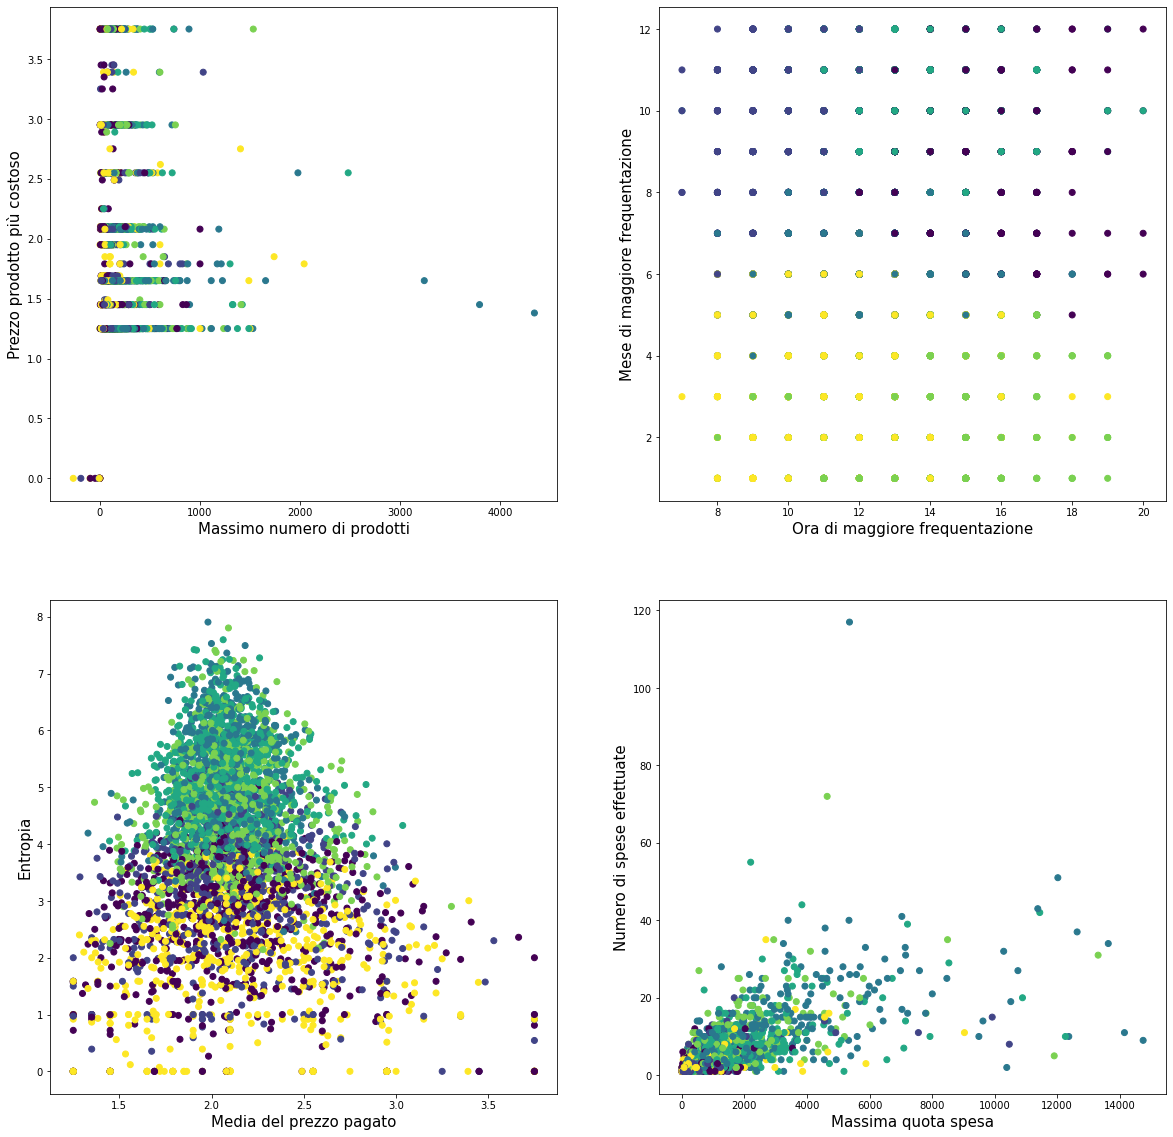

In [42]:

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].set_xlabel("Massimo numero di prodotti", fontsize=15)
ax[0, 0].set_ylabel("Prezzo prodotto più costoso", fontsize=15)
ax[0, 0].scatter(
    x = customer_indicators["Imax"],
    y = customer_indicators["most_bought_cost"],
    c = clusters,
)
ax[0, 1].set_xlabel("Ora di maggiore frequentazione", fontsize=15)
ax[0, 1].set_ylabel("Mese di maggiore frequentazione", fontsize=15)
ax[0, 1].scatter(
    x = customer_indicators["hour"],
    y = customer_indicators["month"],
    c = clusters
)
ax[1, 0].set_xlabel("Media del prezzo pagato", fontsize=15)
ax[1, 0].set_ylabel("Entropia", fontsize=15)
ax[1, 0].scatter(
    x = customer_indicators["avg_bought"],
    y = customer_indicators["E"],
    c = clusters
)
ax[1, 1].set_xlabel("Massima quota spesa", fontsize=15)
ax[1, 1].set_ylabel("Numero di spese effettuate", fontsize=15)
ax[1, 1].scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = clusters
)
plt.savefig("./xmeans.png")

### Sottoinsieme 2

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

labels_two = ["I", "Iu", "Imax", "most_bought_cost", "avg_bought", "E"]

X = scaler.fit_transform(customer_indicators[labels_one].values)

clusters, centers = xmeans_clustering(X, min_clusters=2, max_clusters=6)
clusters = list_to_labels(X, clusters)
clusters

SSE: 283.33319458800355, Silhouette: 0.3385475239296091
Total number of clusters:  6


array([1., 4., 1., ..., 4., 1., 5.])

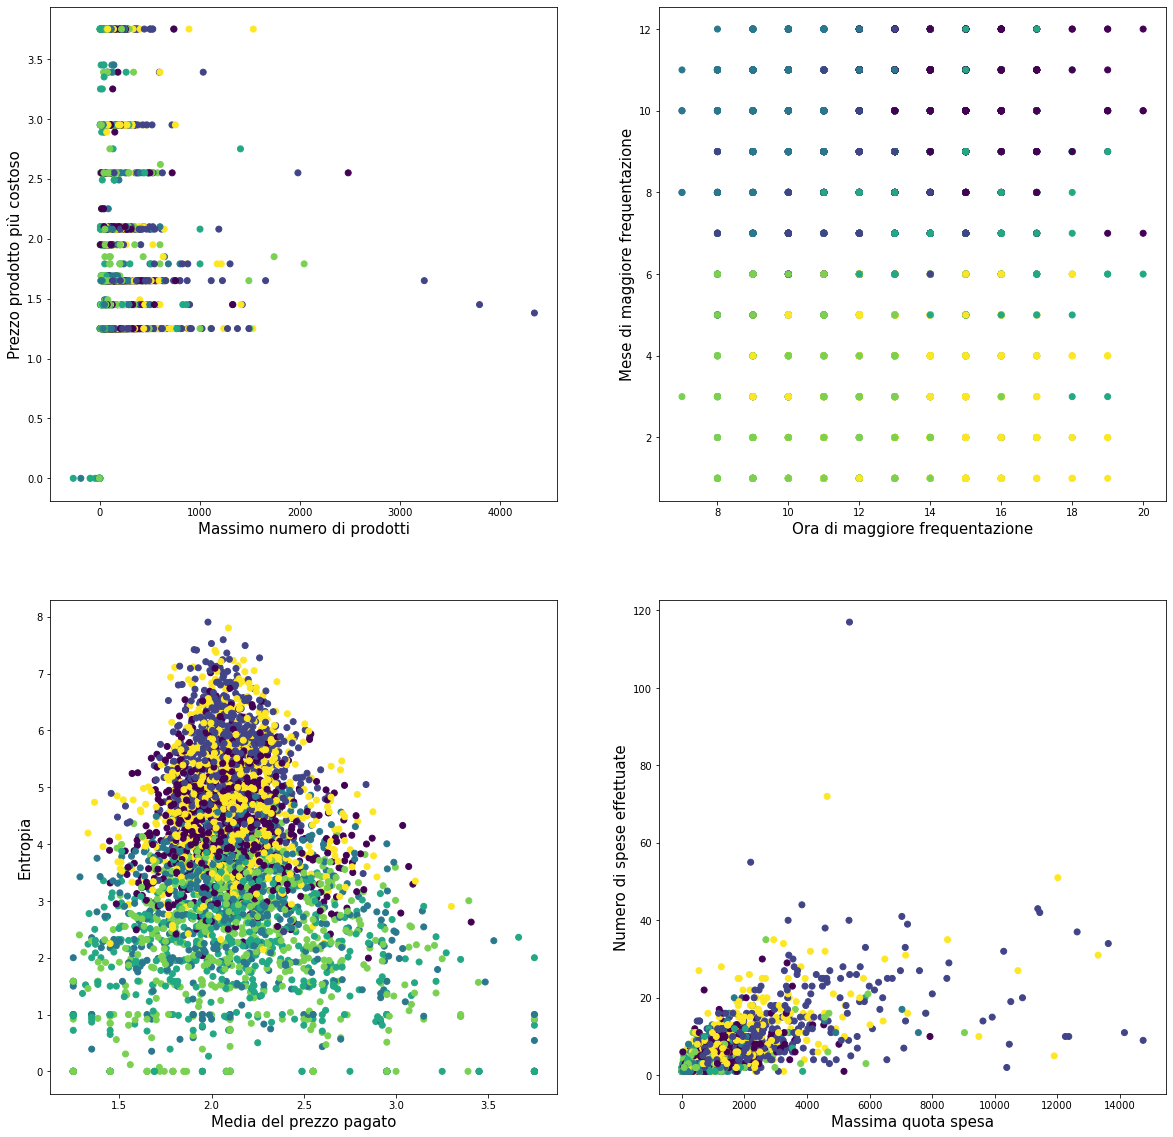

In [44]:

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].set_xlabel("Massimo numero di prodotti", fontsize=15)
ax[0, 0].set_ylabel("Prezzo prodotto più costoso", fontsize=15)
ax[0, 0].scatter(
    x = customer_indicators["Imax"],
    y = customer_indicators["most_bought_cost"],
    c = clusters,
)
ax[0, 1].set_xlabel("Ora di maggiore frequentazione", fontsize=15)
ax[0, 1].set_ylabel("Mese di maggiore frequentazione", fontsize=15)
ax[0, 1].scatter(
    x = customer_indicators["hour"],
    y = customer_indicators["month"],
    c = clusters
)
ax[1, 0].set_xlabel("Media del prezzo pagato", fontsize=15)
ax[1, 0].set_ylabel("Entropia", fontsize=15)
ax[1, 0].scatter(
    x = customer_indicators["avg_bought"],
    y = customer_indicators["E"],
    c = clusters
)
ax[1, 1].set_xlabel("Massima quota spesa", fontsize=15)
ax[1, 1].set_ylabel("Numero di spese effettuate", fontsize=15)
ax[1, 1].scatter(
    x = customer_indicators["spending"],
    y = customer_indicators["baskets"],
    c = clusters
)
plt.savefig("./xmeans.png")